<a href="https://colab.research.google.com/github/27100340/ai-ml-pa2/blob/main/Group(group_number)_S(section_number)_PA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>

# **PA2: Classification**

### **Total : 1000 marks**

</center>

**Group Number:**

Name:

Roll Number:

Name:

Roll Number:


## Instructions

- Follow along with the notebook, filling out the necessary code where instructed.

- <span style="color: red;">Make sure to run all cells for credit.</span>

- <span style="color: red;">Do not remove any pre-written code (unless explicitly mentioned in the cell that you are allowed to do so).</span>

- <span style="color: red;">You must attempt all parts.</span>

## Submission Guidelines

You are to submit a zip file containing the following files:

1. This juptyer notebook. `Group<group_number>_S<section_number>_PA2.ipynb`
2. Python file of the juptyer notebook. `Group<group_number>_S<section_number>_PA2.py`

For example if I am from S1 and my group number is 25, my files would be named `Group25_S1_PA2.ipynb` and `Group25_S1_PA2.py`

IMPORTANT: **Do not zip the files.** Submit both the files seperately, without zipping them.


# Part 1: k-NNs from Scratch (400 marks)

You are <span style="color: red;">not allowed</span> to use scikit-learn or any other machine learning toolkit for this part. You have to implement your own k-NN classifier from scratch.

### Importing Libraries

All of the necessary libraries for this part have been imported for you below. You may not use any other library apart from standard Python librares.


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import PIL
!pip install idx2numpy
!pip install tqdm
from tqdm.notebook import tqdm
import idx2numpy
import cupy as cp
import time
# hellop

  Preparing metadata (setup.py) ... done
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7904 sha256=50787653febd78e468953be821069d376fa4f3be9c90b49f4c1c340f49447651
  Stored in directory: /root/.cache/pip/wheels/e0/f4/e7/643fc5f932ec2ff92997f43f007660feb23f948aa8486f1107
Successfully built idx2numpy


### Task 1.1: Extracting the dataset

The MNIST dataset consists of 70,000 labeled images of handwritten digits, each of size 28 pixels by 28 pixels, yielding a total of 784 pixels per picture.

Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This value ranges from 0-255

The dataset can be downloaded from [here](https://www.kaggle.com/datasets/hojjatk/mnist-dataset) and is also available to in your assignment directory. The four relevant files in the folder are:

- train-images-idx3-ubyte: training set images
- train-labels-idx1-ubyte: training set labels
- t10k-images-idx3-ubyte: test set images
- t10k-labels-idx1-ubyte: test set labels

The dataset has been split with 60,000 images in the train set, and the remaning 10,000 images in the test set.

Your very first task is to to convert this dataset into a pandas dataframe.

Hint: _use the idx2numpy package to convert the dataset to a multidimensional numpy array. The documentation can be visited [here](https://pypi.org/project/idx2numpy/). The resulting array then has to be flattened._


In [16]:
# Input the file paths
train_images_path = "/kaggle/input/mnistt/train-images.idx3-ubyte"
train_labels_path = "/kaggle/input/mnistt/train-labels.idx1-ubyte"
test_images_path = "/kaggle/input/mnistt/t10k-images.idx3-ubyte"
test_labels_path = "/kaggle/input/mnistt/t10k-labels.idx1-ubyte"

# Convert the idx files to NumPy
train_set_images = idx2numpy.convert_from_file(train_images_path)
train_set_labels = idx2numpy.convert_from_file(train_labels_path)
test_set_images = idx2numpy.convert_from_file(test_images_path)
test_set_labels = idx2numpy.convert_from_file(test_labels_path)

# Convert NumPy arrays to CuPy arrays
train_set_images = cp.array(train_set_images)
train_set_labels = cp.array(train_set_labels)
test_set_images = cp.array(test_set_images)
test_set_labels = cp.array(test_set_labels)

# Print the shape of the arrays directly (CuPy supports .shape)
print(f"Training images array shape: {train_set_images.shape}")
print(f"Test images array shape: {test_set_images.shape}")

Training images array shape: (60000, 28, 28)
Test images array shape: (10000, 28, 28)


In [17]:
# TODO: Flatten the array, append the labels and print the shape again
# The shape of your train set should be (60000, 785), and test set should be (10000, 785)
# IMPORTANT: If your shapes are not matching, dont attempt the rest of the assignment unless you get it right.
# Ensure data is in CuPy format before using cp.column_stack
# Flatten images (reshape while keeping them as CuPy arrays)
train_set_images_flatten = train_set_images.reshape(60000, -1)
test_set_images_flatten = test_set_images.reshape(10000, -1)

# Ensure labels are column vectors for stacking
train_set_labels = train_set_labels.reshape(-1, 1)
test_set_labels = test_set_labels.reshape(-1, 1)

# Stack images and labels using CuPy
train_with_labels = cp.column_stack((train_set_images_flatten, train_set_labels))
test_with_labels = cp.column_stack((test_set_images_flatten, test_set_labels))

# Print shapes (convert back to NumPy only for printing)
print(f"train_with_labels.shape: {train_with_labels.shape}")
print(f"test_with_labels.shape: {test_with_labels.shape}")


train_with_labels.shape: (60000, 785)
test_with_labels.shape: (10000, 785)


Q. What does each row of the dataset represents?


Ans.


### Task 1.2: Visualizing and preprocessing the dataset

Now that we have a dataset to work with, we need to preprocess it further, before we pass it through our classifier. In this step, we will be seperating out the labels from the inputs, and attempt to standardize or normalize our dataset.

Note that the standardization of a variable $x$ refers to:

$$
x' = \frac{x - μ}{σ}
$$

where $μ$ is the mean of the variable and $σ$ is the standard deviation.

On the other hand, variable normalization usually involves scaling the data to a specific range.

You can read more about this [here](https://www.simplilearn.com/normalization-vs-standardization-article).

After you've loaded and split the dataset, let's display some images. You can reshape these 784 values for each image, into a `28x28` array, then use either `matplotlib` or `PIL` to display the image.


In [18]:
# TODO: Extract labels and features
train_x = train_with_labels[:, :-1]
train_y = train_with_labels[:, -1]
test_x = test_with_labels[:, :-1]
test_y = test_with_labels[:, -1]

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)


(60000, 784)
(60000,)
(10000, 784)
(10000,)


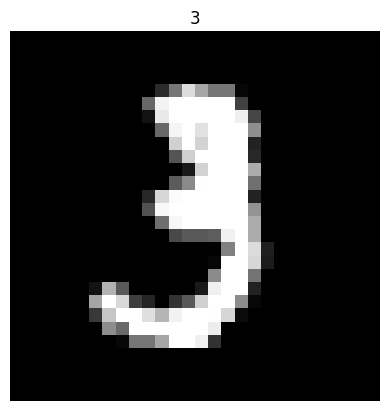

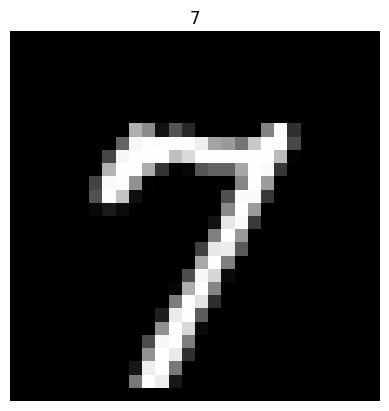

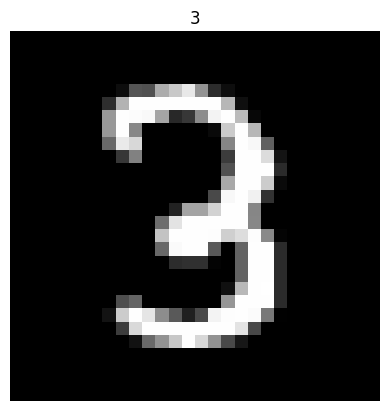

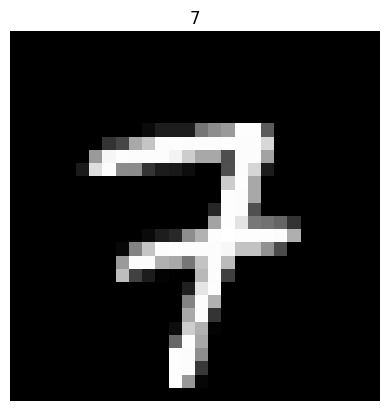

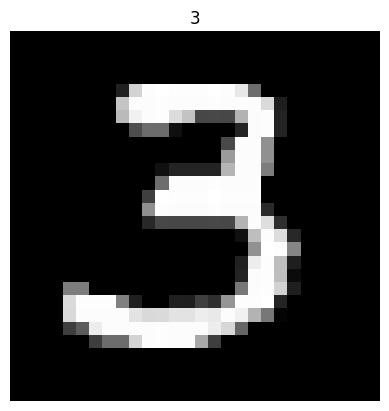

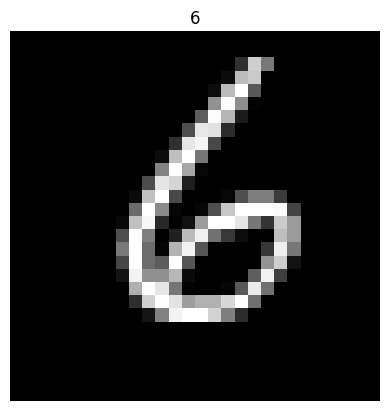

In [19]:
# TODO: Implement a function to display image. The label should be used as a title
#      Randomly pick 5 rows from the training dataset and display their images
row_test = train_x[10, :]
row_test_label = train_y[10]

def display_image(features, label):
    '''
      Takes a 1D numpy array, reshapes to a 28x28 array and displays the image
    '''
    image = cp.asnumpy(features).reshape(28, 28)  # Convert CuPy to NumPy for plotting
    plt.imshow(image, cmap='gray')
    plt.title(f"{cp.asnumpy(label)}")
    plt.axis('off')
    plt.show()
    return None

display_image(row_test, row_test_label)

random_index = cp.random.choice(train_x.shape[0], 5, replace=False)
for i in random_index:
    display_image(train_x[i, :], train_y[i])

In [20]:
# TODO: normalize the data so that it falls in the [0, 1] range.
#      Hint: the max value of each pixel is 255
print("Type of train_x before normalization:", type(train_x))
def normalize(data):
    '''
      scales the data to the range [0, 1]
    '''
    return data / 255.0

train_x = normalize(train_x)
test_x = normalize(test_x)

print(train_x.shape)
print(test_x.shape)

Type of train_x before normalization: <class 'cupy.ndarray'>
(60000, 784)
(10000, 784)


Q. With the variable standardization formula shown above in the description, is this technique feasible in this dataset? Explain in detail.


Ans.


### Task 1.3: Implementing k-NN Classifier

Now you can create your own k-NN classifier. You can use the following steps as a guide:

1. For a test data point, find its distance from all training instances.

2. Sort the calculated distances in ascending order based on distance values.

3. Choose k training samples with minimum distances from the test data point.

4. Return the _most frequent_ class of these samples.

For values of `k` where a tie occurs, you need to break the tie by backing off to the `k-1` value. In case there is still a tie, you will continue decreasing `k` until there is a clear winner.

#### Important

**Note:** Your function should work with _Euclidean_ distance as well as _Manhattan_ distance. Pass the distance metric as a parameter in the k-NN classifier function. Your function should also let one specify the value of `k`.

**Note:** Your approach should be vectorized. Failure to implement a vectorization-based method to calculate distances will result in significant loss of marks. You can read up vectorization [here](https://towardsdatascience.com/vectorization-implementation-in-machine-learning-ca652920c55d)

#### Distance functions

Implement separate functions for the Euclidean and Manhattan distances. Formulas for both are given below.

$$
d_{\text{Euclidean}}(\vec{p},\vec{q}) = \sqrt{(p_1 - q_1)^2 + (p_2 - q_2)^2 + (p_3 - q_3)^2 + ... + (p_n - q_n)^2}
$$

$$
d_{\text{Manhattan}}(\vec{p},\vec{q}) = |(p_1 - q_1)| + |(p_2 - q_2)| + |(p_3 - q_3)| + ... + |(p_n - q_n)|
$$

---

Complete the following method functions:

- `euclidean_distance`
- `manhattan_distance`
- `fit`
- `get_neighbors`
- `predict`


In [21]:
class KNN:
    def __init__(self, k):
        '''
        Initializes the class.
        '''
        self.k = k
        self.train_x = None
        self.train_y = None

    def euclidean_distance(self, x1, x2):
        '''
        Takes two cupy arrays and calculates the Euclidean distance between them.
        x1: single test point (shape: (784,))
        x2: training set (shape: (n_samples, 784))
        '''
        # print("Calculating Euclidean distances...")
        euc_dist_square = cp.sum((x1 - x2) ** 2, axis=1)
        euc_dist = cp.sqrt(euc_dist_square)
        # print("Done!\n")
        return euc_dist

    def manhattan_distance(self, x1, x2):
        '''
        Takes two cupy arrays and calculates the Manhattan distance between them.
        x1: single test point (shape: (784,))
        x2: training set (shape: (n_samples, 784))
        '''
        # print("Calculating Manhattan distances...\n")
        man_dist1 = cp.abs(x1 - x2)
        man_res = cp.sum(man_dist1, axis=1)
        # print("Done!\n")
        return man_res

    def fit(self, train_x, train_y):
        '''
        Stores the training dataset.
        '''
        self.train_x = train_x
        self.train_y = train_y
        return None

    def get_neighbors(self, new_point, distancefunc):
        '''
        Takes a new point and returns the k nearest neighbors.
        '''
        if distancefunc == 'euclidean':
            distances = self.euclidean_distance(new_point, self.train_x)
        else:
            distances = self.manhattan_distance(new_point, self.train_x)

        sort = cp.argsort(distances)
        nk_index = sort[:self.k]
        nk_label = self.train_y[nk_index]
        return nk_label

    def predict(self, test_x, distancefunc):
        '''
        Takes a test set and returns the predicted labels.
        Displays a progress bar for the prediction process.
        '''
        predictions = []
        for i in tqdm(range(test_x.shape[0]), desc="Predicting"):
            k_val = self.k
            prediction = None
            while k_val > 0:
                if distancefunc == 'euclidean':
                    distances = self.euclidean_distance(test_x[i], self.train_x)
                else:
                    distances = self.manhattan_distance(test_x[i], self.train_x)

                sorted_indices = cp.argsort(distances)
                neighbor_indices = sorted_indices[:k_val]
                neighbor_labels = self.train_y[neighbor_indices]
                votes, counts = cp.unique(neighbor_labels, return_counts=True)

                if cp.sum(counts == cp.max(counts)) == 1:  # No tie
                    prediction = votes[cp.argmax(counts)]
                    break
                else:
                    k_val -= 1  # Reduce k if tie

            if prediction is None:  # Fallback if all k values tie
                nns = self.get_neighbors(test_x[i], distancefunc)
                votes, counts = cp.unique(nns, return_counts=True)
                prediction = votes[cp.argmax(counts)]
            predictions.append(prediction)
        return cp.array(predictions)

### Task 1.4: Evaluation

Now that you've created a model and "trained" it, you can move on to the Evaluation phase.

- We will be implementing an `evaluate` function that computes the Confusion Matrix, Accuracy, and Macro-Average F1 score of your classifier. You can use multiple helper functions to calculate the individual metrics.

- The function should take as input the predicted labels and the true labels. This will be built in steps: its easier to create a Confusion Matrix, then calculate things like the Precision, Recall and F1 from it.

- We will also implement a function that displays our confusion matrix as a heatmap annotated with the data values.
- The axes should be properly labelled and the colormap used needs to be shown next to the heatmap.
- You can have a look at some examples of heatmaps [here](https://seaborn.pydata.org/generated/seaborn.heatmap.html). (You don't have to use the seaborn libray, but it has some pretty colour palettes to choose from.)

We recommend that you do not use hard coding in this function.

---

Complete the following functions:

- `accuracy`
- `make_confusion_matrix`
- `make_heat_map`
- `precision`
- `recall`
- `f1_score`
- `macro_average_f1`
- `evaluate`


In [22]:
def make_confusion_matrix(predicted_labels, true_labels):
    '''
      Takes the predicted labels and the true labels and returns the confusion matrix
      Hint: You can create a helper function which calculates each row of the confusion matrix
    '''
    predicted_labels = cp.asarray(predicted_labels, dtype=cp.int32)
    true_labels = cp.asarray(true_labels, dtype=cp.int32)
    classes = int(cp.max(cp.concatenate((true_labels, predicted_labels))) + 1)
    conf_matrix = cp.zeros((classes, classes), dtype=cp.int32)
    cp.add.at(conf_matrix, (true_labels, predicted_labels), 1)
    return conf_matrix

# helper
def accuracy_helper(conf_matrix):
    total = cp.sum(conf_matrix)
    TP = cp.trace(conf_matrix)
    FN = total - TP
    TN = 0  # Not used in multi-class accuracy
    FP = 0  # Not used in multi-class accuracy
    return TN, TP, FN, FP

def accuracy(predicted_labels, true_labels):
    '''
      Takes the predicted labels and the true labels and returns the accuracy
    '''
    conf_matrix = make_confusion_matrix(predicted_labels, true_labels)
    correct = cp.trace(conf_matrix)  # Sum of diagonal (correct predictions)
    total = cp.sum(conf_matrix)      # Total number of predictions
    return correct / total

def precision(confusion_matrix, class_label):
    '''
      Takes the confusion matrix and a label and returns the precision
    '''
    tp = confusion_matrix[class_label, class_label]
    fp = cp.sum(confusion_matrix[:, class_label]) - tp
    return tp / (tp + fp) if (tp + fp) != 0 else 0

def recall(confusion_matrix, class_label):
    '''
      Takes the confusion matrix and a label and returns the recall
    '''
    tp = confusion_matrix[class_label, class_label]
    fn = cp.sum(confusion_matrix[class_label, :]) - tp
    return tp / (tp + fn) if (tp + fn) != 0 else 0

def f1_score(precision, recall):
    '''
      Takes the precision and recall and returns the f1 score
    '''
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

def macro_average_f1(confusion_matrix):
    '''
    Calculates the macro-average F1 score from a provided confusion matrix, over all classes
    '''
    num_classes = confusion_matrix.shape[0]
    f1_scores = []
    for class_label in range(num_classes):
        prec = precision(confusion_matrix, class_label)
        rec = recall(confusion_matrix, class_label)
        f1 = f1_score(prec, rec)
        f1_scores.append(f1)  # f1 is a CuPy scalar
    return cp.mean(cp.array(f1_scores))  # Convert list to CuPy array and compute mean

def make_heat_map(confusion_matrix, title):
    '''
      Takes the confusion matrix and plots it as a heatmap
    '''
    # This function has already been implemented
    plt.figure(figsize=(10, 7))
    sns.heatmap(cp.asnumpy(confusion_matrix), annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    return None

def evaluate(predicted_labels, true_labels):
    '''
      Displays and returns a nicely formatted report with accuracy, macro-average f1 score, and confusion matrix
    '''
    conf_matrix = make_confusion_matrix(predicted_labels, true_labels)
    acc = accuracy(predicted_labels, true_labels)
    macro_f1 = macro_average_f1(conf_matrix)
    # Convert CuPy scalars to Python scalars for printing
    acc_val = cp.asnumpy(acc).item()
    macro_f1_val = cp.asnumpy(macro_f1).item()
    print("Evaluation Results:\n")
    print(f"Accuracy: {acc_val}")
    print(f"Macro-Average F1 Score: {macro_f1_val}")
    print(f"Confusion Matrix:\n{cp.asnumpy(conf_matrix)}")
    make_heat_map(conf_matrix, "Heat Map")
    return acc, macro_f1

### Task 1.5: k-fold Cross Validation

<center>
    <img src="https://global.discourse-cdn.com/dlai/original/3X/a/3/a3ed2de61c2b4fa00f1b7e939753e1a7e181afb0.png">
</center>

Now with the basics done, you can move on to the next step: k-fold Cross Validation. This is a more robust way of evaluating your model since it uses all the data for training and testing (effectively giving you `k` chances to verify the generalizability of your model).

Now, implement a function that performs `k`-fold cross-validation on the training data for a specified value of `k`.

In Cross Validation, you divide the dataset into `k` parts. `k-1` parts will be used for training and `1` part will be used for validation. You will repeat this process `k` times, each time using a different part for validation. You will then average the results of each fold to get the final result. Take a look at the image above for a better understanding.

The function should return **predictions** for the **entire training data** (size of list/array should be equal to the size of the dataset). This is the result of appending the predicted labels for each validation-train split into a single list/array. Make sure the order of the predicted labels matches the order of the training dataset, so that they may directly be passed to your `evaluate` function together with the actual labels.

---

Complete the following functions:

- `k_fold_split`
- `k_fold_cross_validation`


In [23]:
def k_fold_split(num_folds, cv_no, train_x, train_y):
    '''
    Creates the train and test splits based off the value of k

    Parameters
    ----------
    mum_folds : int
        Number of folds
    cv_no : int
        The current fold number
    train_x : nparray
        The features
    train_y : nparray
        The labels
    '''

    total_samples = train_x.shape[0]
    fold_size = total_samples // num_folds
    start_val = (cv_no - 1) * fold_size
    end_val = cv_no * fold_size if cv_no < num_folds else total_samples

    validation_indexes = cp.arange(start_val, end_val)
    train_indexes = cp.concatenate([cp.arange(0, start_val), cp.arange(end_val, total_samples)])

    train_part_x = train_x[train_indexes]
    train_part_y = train_y[train_indexes]
    validate_x = train_x[validation_indexes]
    validate_y = train_y[validation_indexes]

    return train_part_x, train_part_y, validate_x, validate_y, validation_indexes


def k_fold_cross_validation(num_folds, k, train_x, train_y, distanceFunction):
    """
    Returns the predictions for all the data points in the dataset using k-fold cross validation

    num_folds: int
      Number of folds
    k: int
      Number of neighbours to consider (hyperparameter)
    train_x : nparray
        The features
    train_y : nparray
        The labels
    distanceFunction : str
        Distance metric specified (manhattan / euclidean)
    """
    all_predictions = []
    for cv_no in range(1, num_folds + 1):
        train_part_x, train_part_y, validate_x, validate_y, validation_indexes = k_fold_split(num_folds, cv_no, train_x, train_y)
        model = KNN(k)
        model.fit(train_part_x, train_part_y)
        
        predictions = model.predict(validate_x, distanceFunction)
        all_predictions.append(predictions)
    return cp.concatenate(all_predictions)


Now run your cross-validation function on the training data using `5-fold cross validation` for the values of `k = [1, 2, 3, 4, 5]`.

Do this for both the Euclidean distance and the Manhattan distance for each value of `k`.

Also run your evaluation function for each value of `k` (for both distance metrics) and print out the classification accuracy and F1 score.

**Note: Save your evaluation stats for plotting later**


In [24]:
# Save scores here for plotting later
# accuracy_list_euclidean = []
# f1_list_euclidean = []
# accuracy_list_manhattan = []
# f1_list_manhattan = []

# For K fold cross validation you can randomly sample a subset of training dataset to conduct your cross validation on.
# The size of this dataset should be 14000.
# This should significantly cut down the run time.
# This has already been implemented for you in this cell
# Now use sampled_train_x and sampled_train_y in the next cell

accuracy_list_euclidean = []
f1_list_euclidean = []
accuracy_list_manhattan = []
f1_list_manhattan = []


data = cp.hstack((train_x, train_y.reshape(-1, 1)))
sampled_data = data[cp.random.choice(data.shape[0], 14000, replace=False)]
sampled_train_x = sampled_data[:, :-1]
sampled_train_y = sampled_data[:, -1]

print(sampled_train_x)
print(sampled_train_y)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[7. 0. 8. ... 8. 5. 3.]


Manhattan DISTANCE
Current Value of K: 1


Manhattan Distance Processing...:   0%|          | 0/50 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]


K value (current): 1 for Manhattan DISTANCE

Evaluation Results:

Accuracy: 0.9415714285714286
Macro-Average F1 Score: 0.9413624520512945
Confusion Matrix:
[[1377    2    1    2    0    2    7    1    0    3]
 [   0 1538    2    2    3    1    1    5    0    1]
 [  16   12 1287    6    5    3    2   36    3    3]
 [   2    6   16 1351    2   47    3   14   16   10]
 [   0   21    1    1 1261    3    6    8    1   69]
 [   7    8    2   38    8 1223   21    3    5    9]
 [   7    4    0    0    1   14 1281    0    0    0]
 [   1   27    2    0    7    0    0 1362    2   17]
 [   5   35    8   35    7   49    8   10 1239   27]
 [   5    5    0   13   30    5    1   46    1 1263]]


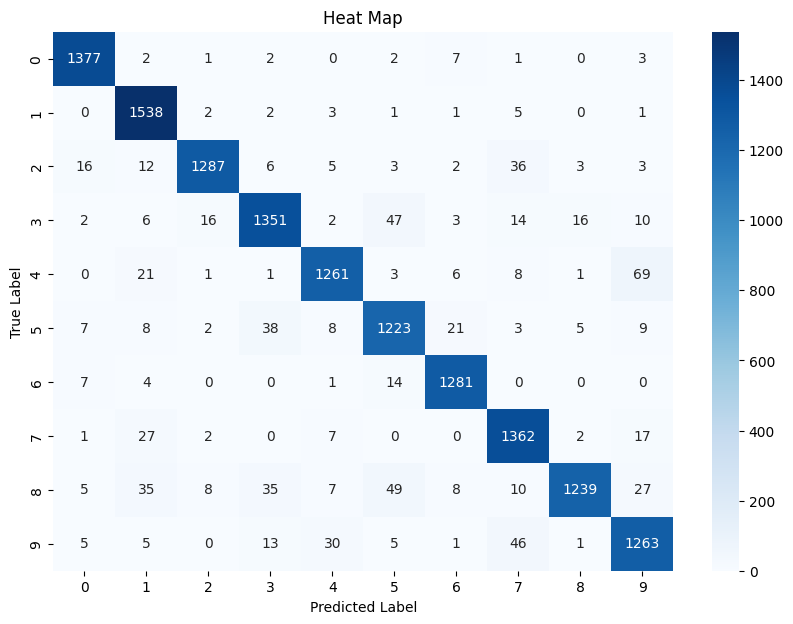

Current Value of K: 2


Manhattan Distance Processing...:   0%|          | 0/50 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]


K value (current): 2 for Manhattan DISTANCE

Evaluation Results:

Accuracy: 0.9415714285714286
Macro-Average F1 Score: 0.9413624520512945
Confusion Matrix:
[[1377    2    1    2    0    2    7    1    0    3]
 [   0 1538    2    2    3    1    1    5    0    1]
 [  16   12 1287    6    5    3    2   36    3    3]
 [   2    6   16 1351    2   47    3   14   16   10]
 [   0   21    1    1 1261    3    6    8    1   69]
 [   7    8    2   38    8 1223   21    3    5    9]
 [   7    4    0    0    1   14 1281    0    0    0]
 [   1   27    2    0    7    0    0 1362    2   17]
 [   5   35    8   35    7   49    8   10 1239   27]
 [   5    5    0   13   30    5    1   46    1 1263]]


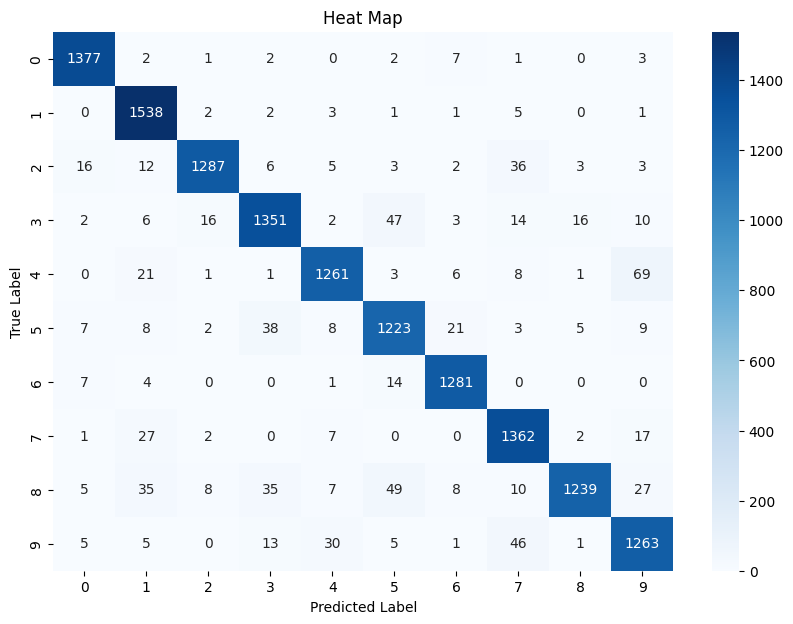

Current Value of K: 3


Manhattan Distance Processing...:   0%|          | 0/50 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]


K value (current): 3 for Manhattan DISTANCE

Evaluation Results:

Accuracy: 0.9451428571428572
Macro-Average F1 Score: 0.9451191229235164
Confusion Matrix:
[[1376    2    1    1    0    2    9    0    0    4]
 [   0 1540    4    3    1    1    1    2    0    1]
 [  14   27 1284    2    3    3    2   32    5    1]
 [   2    5   15 1374    2   32    2   15   13    7]
 [   1   28    0    0 1258    2    4    7    0   71]
 [   6   11    2   25    7 1238   16    4    3   12]
 [   5    7    0    0    0   14 1281    0    0    0]
 [   1   30    3    0    4    0    0 1361    1   18]
 [   4   38    7   33    8   47    9    8 1243   26]
 [   5    8    0   16   19    3    3   37    1 1277]]


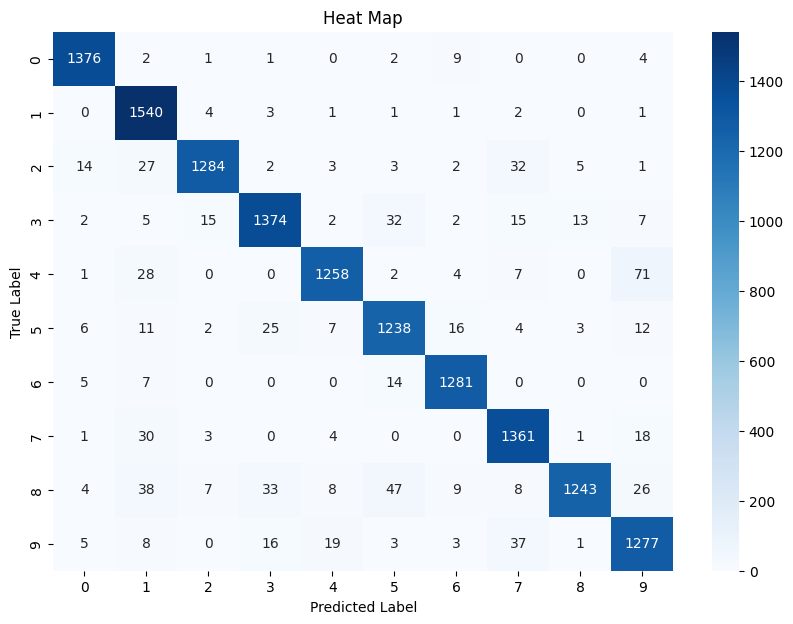

Current Value of K: 4


Manhattan Distance Processing...:   0%|          | 0/50 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]


K value (current): 4 for Manhattan DISTANCE

Evaluation Results:

Accuracy: 0.9447142857142857
Macro-Average F1 Score: 0.9447086394653017
Confusion Matrix:
[[1377    1    1    1    0    3    9    0    0    3]
 [   0 1540    4    3    1    1    1    2    0    1]
 [  13   30 1281    2    3    3    2   33    4    2]
 [   3    8   13 1373    2   30    2   18   13    5]
 [   1   28    0    0 1256    0    5    8    0   73]
 [   6   13    2   20    6 1240   16    3    3   15]
 [   6    7    0    0    0   13 1281    0    0    0]
 [   1   30    4    0    6    0    0 1360    0   17]
 [   6   39    6   28    9   49   11    6 1239   30]
 [   3    9    1   17   17    3    3   34    3 1279]]


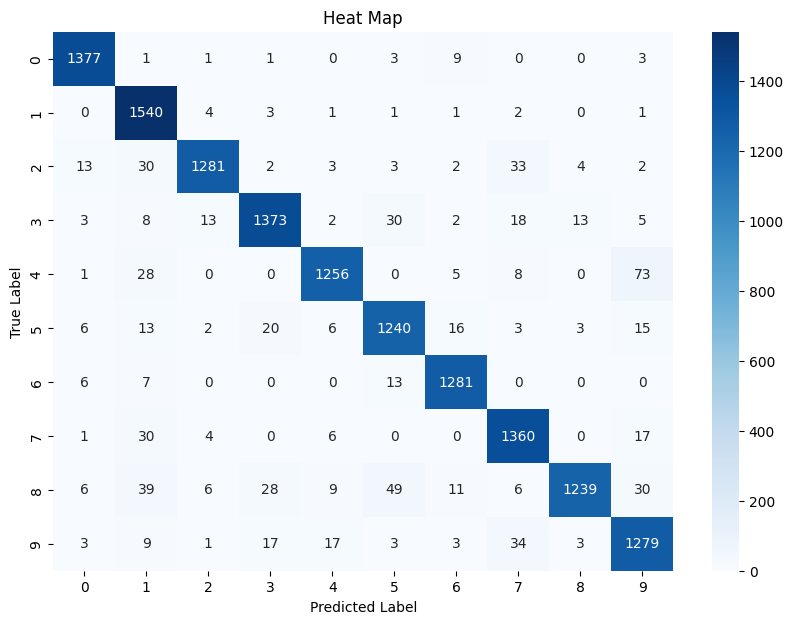

Current Value of K: 5


Manhattan Distance Processing...:   0%|          | 0/50 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]


K value (current): 5 for Manhattan DISTANCE

Evaluation Results:

Accuracy: 0.9437142857142857
Macro-Average F1 Score: 0.9438126097518456
Confusion Matrix:
[[1377    1    1    1    0    3    9    0    0    3]
 [   0 1540    4    4    1    0    1    2    0    1]
 [  14   41 1262    3    3    3    2   38    6    1]
 [   2    9   12 1373    3   28    2   17   14    7]
 [   1   30    0    0 1257    0    5    8    0   70]
 [   5   13    2   16    7 1245   14    3    4   15]
 [   6    6    0    0    0   11 1284    0    0    0]
 [   1   32    4    0    6    0    0 1353    0   22]
 [   7   43    7   25   10   45   11    7 1236   32]
 [   4    9    1   19   15    2    2   28    4 1285]]


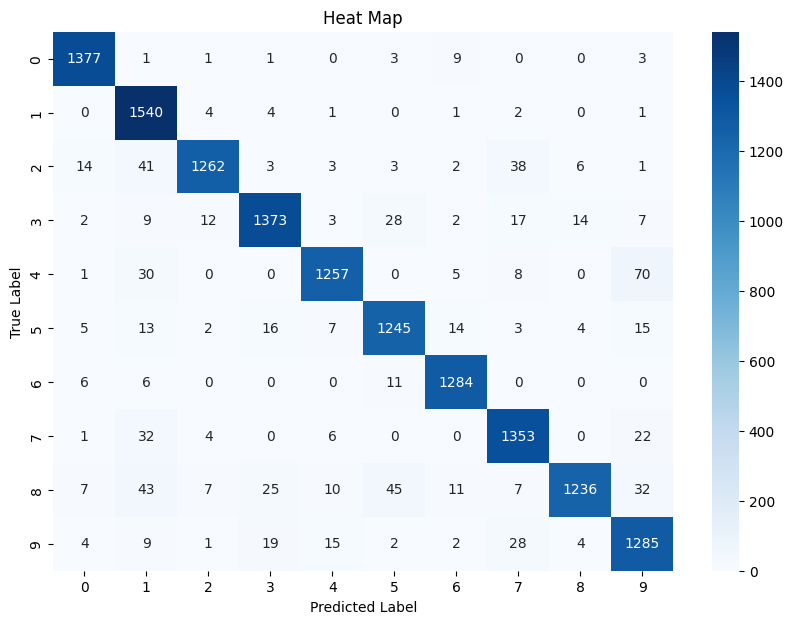

Euclidean DISTANCE

K value (current): 1 for Euclidean DISTANCE



Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Evaluation Results:

Accuracy: 0.9508571428571428
Macro-Average F1 Score: 0.9506738880620007
Confusion Matrix:
[[1379    1    2    1    0    2    8    1    0    1]
 [   0 1535    2    3    3    0    1    7    0    2]
 [  14    9 1302    5    4    3    1   26    7    2]
 [   2    5   15 1372    2   33    2   10   19    7]
 [   1   13    1    1 1275    2    4    6    1   67]
 [   7    6    2   28    6 1237   20    2    6   10]
 [   6    2    0    0    1   13 1284    0    1    0]
 [   1   20    3    0    3    0    0 1367    2   22]
 [   5   23    5   26    5   40    5    7 1280   27]
 [   5    4    0   14   25    4    1   33    2 1281]]


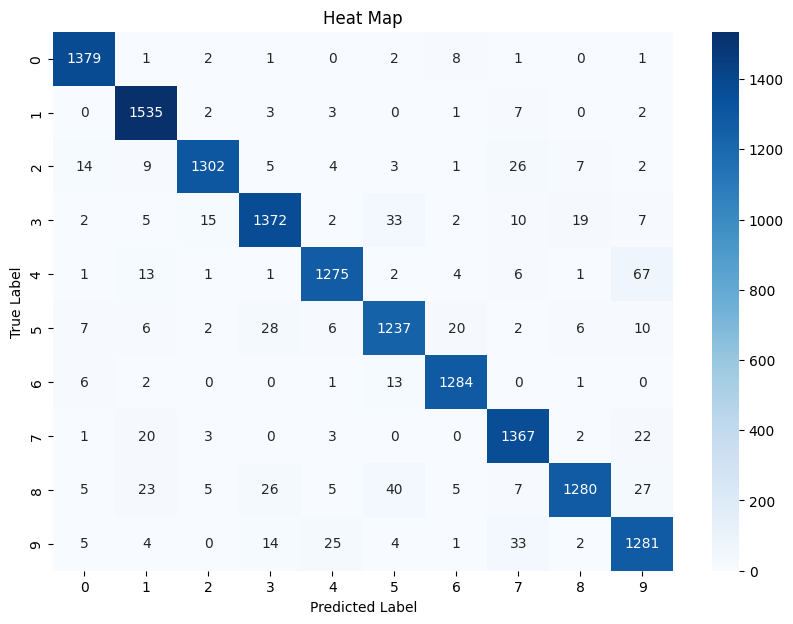


K value (current): 2 for Euclidean DISTANCE



Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Evaluation Results:

Accuracy: 0.9508571428571428
Macro-Average F1 Score: 0.9506738880620007
Confusion Matrix:
[[1379    1    2    1    0    2    8    1    0    1]
 [   0 1535    2    3    3    0    1    7    0    2]
 [  14    9 1302    5    4    3    1   26    7    2]
 [   2    5   15 1372    2   33    2   10   19    7]
 [   1   13    1    1 1275    2    4    6    1   67]
 [   7    6    2   28    6 1237   20    2    6   10]
 [   6    2    0    0    1   13 1284    0    1    0]
 [   1   20    3    0    3    0    0 1367    2   22]
 [   5   23    5   26    5   40    5    7 1280   27]
 [   5    4    0   14   25    4    1   33    2 1281]]


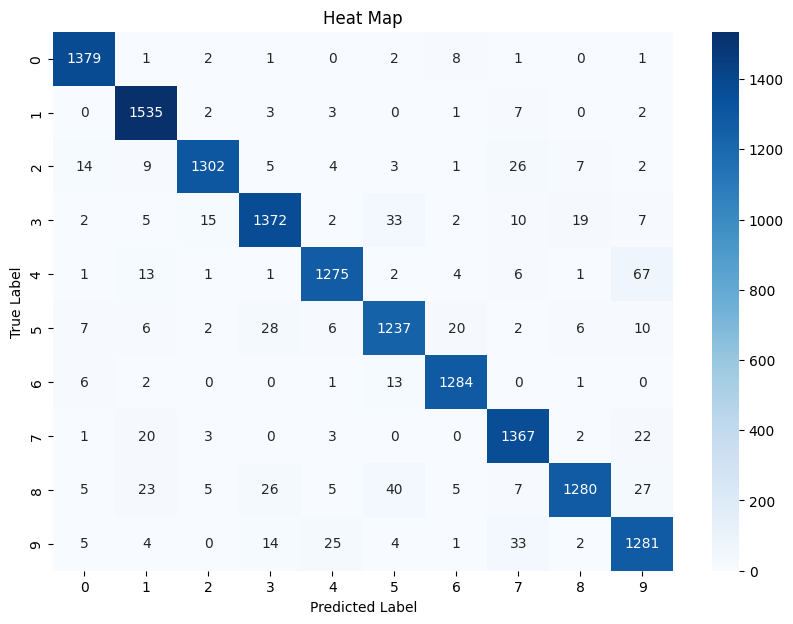


K value (current): 3 for Euclidean DISTANCE



Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Evaluation Results:

Accuracy: 0.9537857142857142
Macro-Average F1 Score: 0.9537031684006273
Confusion Matrix:
[[1380    1    2    1    0    2    7    0    0    2]
 [   0 1538    4    4    1    0    1    3    0    2]
 [  14   14 1301    4    3    4    0   25    7    1]
 [   1    3   13 1387    2   27    1   10   17    6]
 [   1   15    0    0 1280    2    4    4    0   65]
 [   5    6    2   17    5 1257   15    2    4   11]
 [   7    3    0    0    0   13 1284    0    0    0]
 [   1   27    3    0    4    0    0 1359    1   23]
 [   4   27    7   23    5   45    7    7 1275   23]
 [   4    6    0   15   15    3    3   29    2 1292]]


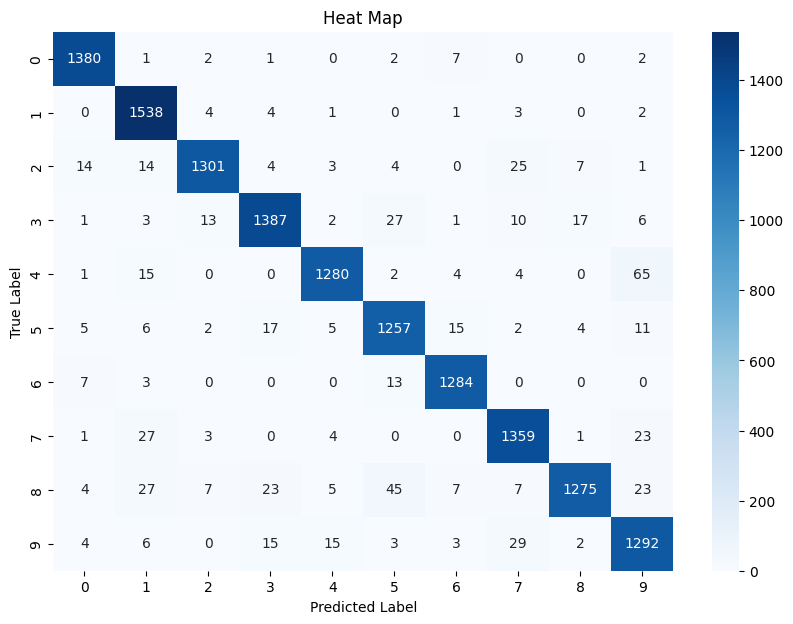


K value (current): 4 for Euclidean DISTANCE



Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Evaluation Results:

Accuracy: 0.9531428571428572
Macro-Average F1 Score: 0.9530855454321093
Confusion Matrix:
[[1381    1    1    1    0    2    7    0    0    2]
 [   0 1538    3    5    1    0    1    3    0    2]
 [  13   16 1297    4    2    5    0   27    8    1]
 [   1    5   12 1385    2   26    1   11   19    5]
 [   1   15    0    0 1279    1    4    6    0   65]
 [   5    8    2   16    3 1255   14    1    6   14]
 [   8    5    0    0    0   13 1281    0    0    0]
 [   1   25    4    0    5    0    0 1361    0   22]
 [   5   28    5   22    7   45    8    5 1273   25]
 [   3    7    1   16   14    2    3   26    3 1294]]


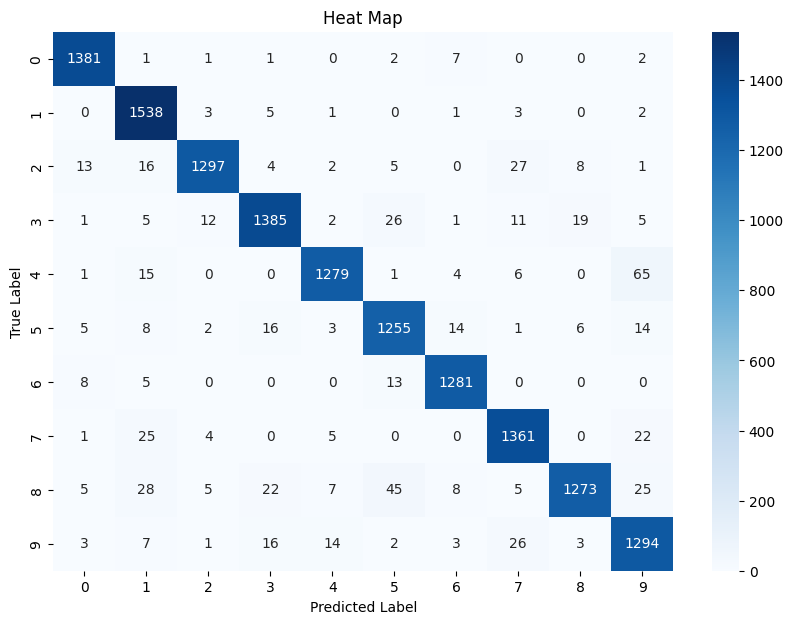


K value (current): 5 for Euclidean DISTANCE



Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Predicting:   0%|          | 0/2800 [00:00<?, ?it/s]

Evaluation Results:

Accuracy: 0.9510714285714286
Macro-Average F1 Score: 0.9510563684608314
Confusion Matrix:
[[1381    1    1    1    0    2    6    0    0    3]
 [   0 1539    4    5    1    0    1    2    0    1]
 [  13   19 1287    5    3    4    1   31    9    1]
 [   0    7   13 1384    3   25    0   12   17    6]
 [   1   21    0    0 1267    0    6    7    0   69]
 [   4    9    2   15    4 1256   13    2    8   11]
 [   8    6    0    0    0   12 1281    0    0    0]
 [   2   26    3    0    6    0    0 1356    0   25]
 [   5   30    5   22    7   45    8    5 1267   29]
 [   5    7    1   17   12    2    2   22    4 1297]]


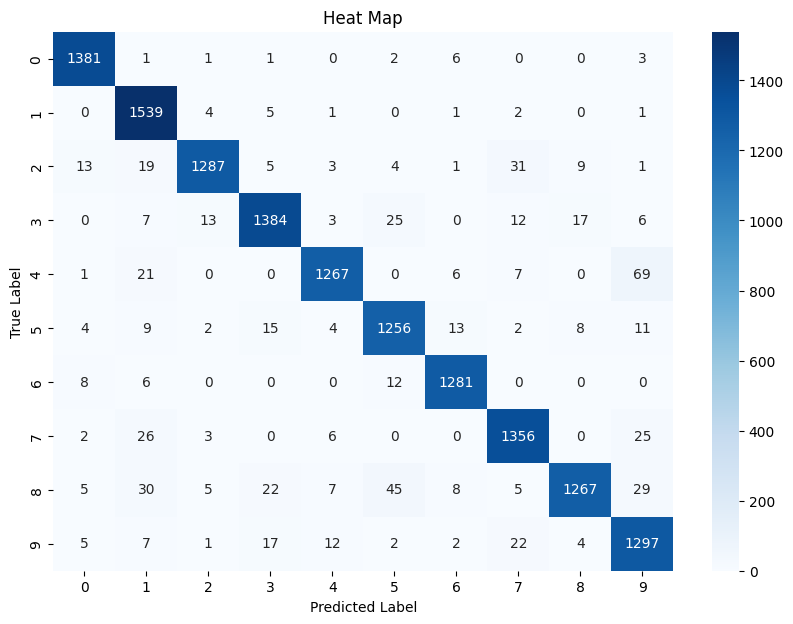

In [25]:
# TODO: Perform cross-validation for both distances and run your evaluation function for each K, printing the accuracy and macro-average F1 score.

num_folds = 5
k_values = [1, 2, 3, 4, 5]

accuracy_list_euclidean = {}
f1_list_euclidean = {}
accuracy_list_manhattan = {}
f1_list_manhattan = {}

print("Manhattan DISTANCE")
for k in k_values:
    print(f"Current Value of K: {k}")
    steps = 50
    pbar = tqdm(total=steps, desc=f"Manhattan Distance Processing...")
    man_pred = k_fold_cross_validation(num_folds, k, sampled_train_x, sampled_train_y, "manhattan")
    time.sleep(0.2)
    pbar.update(1)
    validation_labels_list = []
    # print(f"Progress on K value {k}: #")

    for cv_no in range(1, num_folds + 1):
        # print("#")
        train_x, train_y, val_x, val_y, val_idx = k_fold_split(num_folds, cv_no, sampled_train_x, sampled_train_y)
        # print("#")
        val_labels = sampled_train_y[val_idx]
        # print("#")
        validation_labels_list.append(val_labels)
        # print("#")

    validation_labels = cp.concatenate(validation_labels_list)
    # print("...Done")

    print(f"\nK value (current): {k} for Manhattan DISTANCE\n")
    accuracy_list_manhattan[k], f1_list_manhattan[k] = evaluate(man_pred, validation_labels)

print("Euclidean DISTANCE")
for k in k_values:
    print(f"\nK value (current): {k} for Euclidean DISTANCE\n")
    euc_pred = k_fold_cross_validation(num_folds, k, sampled_train_x, sampled_train_y, "euclidean")
    validation_labels_list = []
    for cv_no in range(1, num_folds + 1):
        train_x, train_y, val_x, val_y, val_idx = k_fold_split(num_folds, cv_no, sampled_train_x, sampled_train_y)
        val_labels = sampled_train_y[val_idx]
        validation_labels_list.append(val_labels)

    validation_labels = cp.concatenate(validation_labels_list)
    accuracy_list_euclidean[k], f1_list_euclidean[k] = evaluate(euc_pred, validation_labels)

Next, present the results as a graph with `k` values on the x-axis and classification accuracy on the y-axis. Use a single plot to compare the two versions of the classifier (one using Euclidean and the other using Manhattan distance metric).

Make another graph but with the F1-score on the y-axis this time. The graphs should be properly labeled on axes, with a title, and a legend.


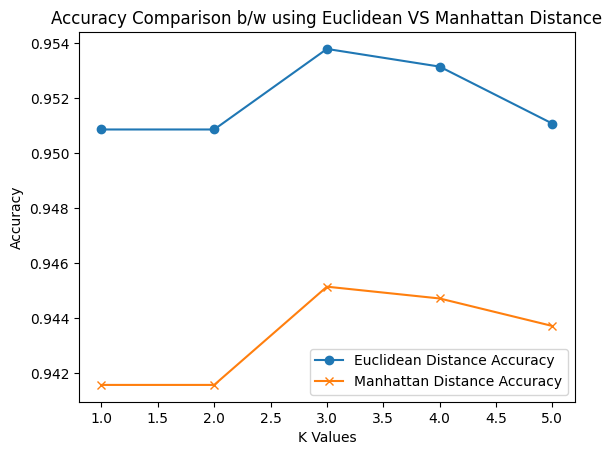

In [26]:
# TODO: Plot a graph with k values on the x-axis and classification accuracy on the y-axis (both distances on one plot).
class EuclideanData:
  def __init__(self, k, accuracy, f1):
    self.k_vals = k
    self.accuracy_vals = {}
    self.f1_vals = {}
    for k, v in accuracy.items():
      numpy_array = v.get()
      self.accuracy_vals[k] = numpy_array
    for k, v in accuracy.items():
      numpy_array = v.get()
      self.f1_vals[k] = numpy_array

  def accuracy_list(self):
    ext = []
    ext = list(self.accuracy_vals.values())
    return ext

  def f1_list(self):
    ext = []
    ext = list(self.f1_vals.values())
    return ext

class ManhattanData:
  def __init__(self, k, accuracy, f1):
    self.k_vals = k
    self.accuracy_vals = {}
    self.f1_vals = {}
    for k, v in accuracy.items():
      numpy_array = v.get()
      self.accuracy_vals[k] = numpy_array
    for k, v in accuracy.items():
      numpy_array = v.get()
      self.f1_vals[k] = numpy_array

  def accuracy_list(self):
    ext = []
    ext = list(self.accuracy_vals.values())
    return ext

  def f1_list(self):
    ext = []
    ext = list(self.f1_vals.values())
    return ext

euclidean_data = EuclideanData(k_values, accuracy_list_euclidean, f1_list_euclidean)
manhattan_data = ManhattanData(k_values, accuracy_list_manhattan, f1_list_manhattan)

plt.plot(euclidean_data.k_vals, euclidean_data.accuracy_list(), label='Euclidean Distance Accuracy', marker='o')
plt.plot(manhattan_data.k_vals, manhattan_data.accuracy_list(), label='Manhattan Distance Accuracy', marker='x')

plt.xlabel('K Values')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison b/w using Euclidean VS Manhattan Distance')

plt.legend()
plt.show()

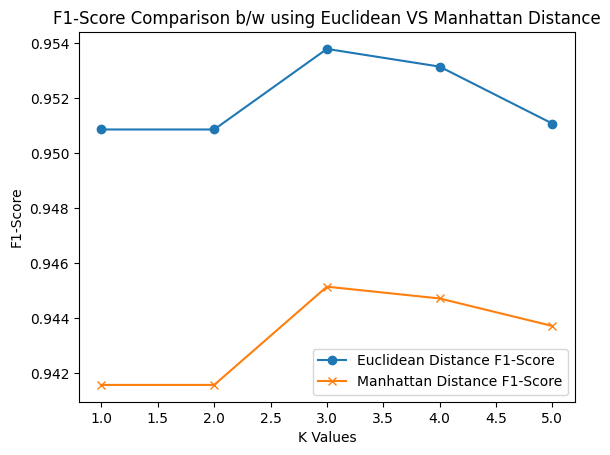

In [27]:
# TODO: Plot a graph with k values on the x-axis and F1-score on the y-axis (both distances on one plot).
plt.plot(euclidean_data.k_vals, euclidean_data.f1_list(), label='Euclidean Distance F1-Score', marker='o')
plt.plot(manhattan_data.k_vals, manhattan_data.f1_list(), label='Manhattan Distance F1-Score', marker='x')

plt.xlabel('K Values')
plt.ylabel('F1-Score')
plt.title('F1-Score Comparison b/w using Euclidean VS Manhattan Distance')

plt.legend()
plt.show()

### Task 1.6: Prediction

Finally, use the best value of `k` for both distance metrics and run it on the test dataset.

Find the confusion matrix, classification accuracy and F1 score and print them.

The confusion matrix must be displayed as a heatmap annotated with the data values. The axes should be properly labelled and the colormap used needs to be shown next to the heatmap.


Best K: 3

Running KNN Model on test Data for Euclidean distance
Starting Prediction process...


Predicting:   0%|          | 0/10000 [00:00<?, ?it/s]

Evaluation Results:

Accuracy: 0.9539
Macro-Average F1 Score: 0.9537041806552786
Confusion Matrix:
[[ 972    1    1    0    0    1    3    1    1    0]
 [   0 1128    2    1    0    0    3    0    0    1]
 [  15   15  967    2    1    0    3   20    8    1]
 [   1    3    3  965    1   16    1    9    5    6]
 [   1   12    0    0  918    0    7    5    1   38]
 [   4    3    0   15    2  850    9    1    2    6]
 [  10    3    0    0    3    3  939    0    0    0]
 [   0   25    4    3    4    0    0  970    0   22]
 [   7    5    2   21    5   28    4   10  881   11]
 [   6    6    3    7   10    5    1   18    4  949]]


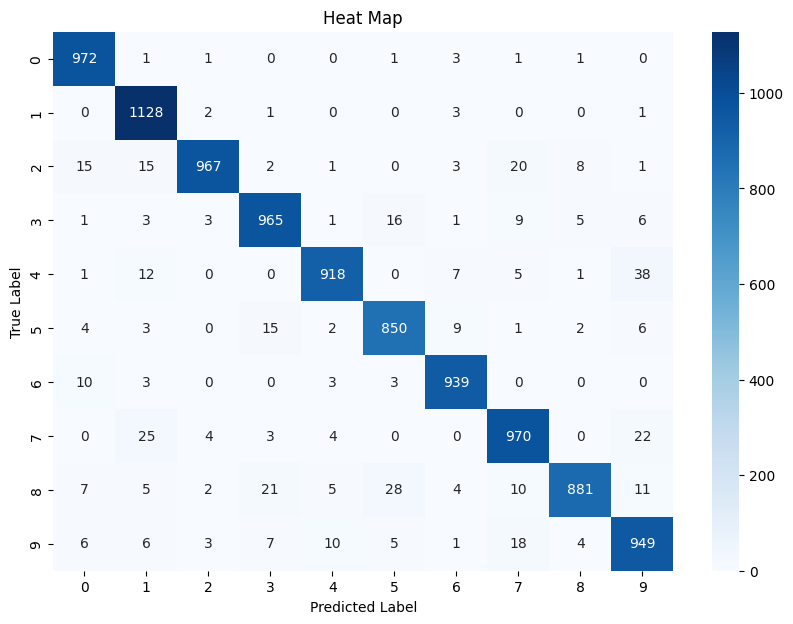

In [28]:
# TODO: Test with the best K for euclidean distance
best_k = None
def findBestKvalue(accuracy_list_euclidean,f1_list_euclidean,accuracy_list_manhattan,f1_list_manhattan):
  best_k_acc_euc = max(accuracy_list_euclidean, key=accuracy_list_euclidean.get)
  best_k_f1_euc = max(f1_list_euclidean, key=f1_list_euclidean.get)
  best_k_acc_man = max(accuracy_list_manhattan, key=accuracy_list_manhattan.get)
  best_k_f1_man = max(f1_list_manhattan, key=f1_list_manhattan.get)
  result = max(best_k_acc_euc,best_k_f1_euc,best_k_acc_man,best_k_f1_man)
  return result

best_k = findBestKvalue(accuracy_list_euclidean,f1_list_euclidean,accuracy_list_manhattan,f1_list_manhattan)
# print(best_k)
print(f"Best K: {best_k}\n")
print("Running KNN Model on test Data for Euclidean distance")
model = KNN(best_k)
model.fit(train_x, train_y)
print("Starting Prediction process...")
predictions = model.predict(test_x, "euclidean")

accuracy_euc, f1_euc = evaluate(predictions, test_y)


In [ ]:
# TODO: Test with the best K for Manhattan distance
# best_k = ...
print("Running KNN Model on test Data for Manhattan distance")
model = KNN(best_k)
model.fit(train_x, train_y)
print("Starting Prediction process...")
predictions = model.predict(test_x, "manhattan")

accuracy_manhattan, f1_manhattan = evaluate(predictions, test_y)



# Part 2: Decision Tree (350 Marks)

A decision tree is a flowchart-like structure in which each internal node represents a test on a feature. Each leaf node represents a class label. The paths from the root to leaf represent classification rules.

Use entropy as the measure of impurity and calculate the information gain to split the nodes.


### Importing necessary libraries for Part 2


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from tqdm.notebook import tqdm 
import seaborn as sns
import cupy as cp

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

## Preparing The Dataset for Part 2


### Task 2.1: Loading the dataset

Read the dataset provided in the file `data.csv` using the pandas library.

1. First, print the number of rows and columns (shape) in the dataset.
2. Print the first 5 rows of the dataset.


In [2]:
# TODO: Load the dataset from the csv file using pandas. The file is called 'data.csv'
data = pd.read_csv('/kaggle/input/pa2-part2-ai/data.csv')
# TODO: Print the shape of the data
print(f"Shape of data: {data.shape}\n")
# TODO: Print the first 5 rows of the data
print("First 5 rows of the data:")
print(data.head())

Shape of data: (2000, 3)

First 5 rows of the data:
         x1        x2    y
0  1.388103  0.541000  1.0
1  0.257498  1.034341  0.0
2  0.481232 -0.175209  1.0
3 -0.925897 -0.221878  0.0
4  0.783837 -0.486287  1.0


### Task 2.2: Visualizing the dataset

Plot a scatter plot of the data. Be sure to label the axes, give the plot a title, and include a legend.


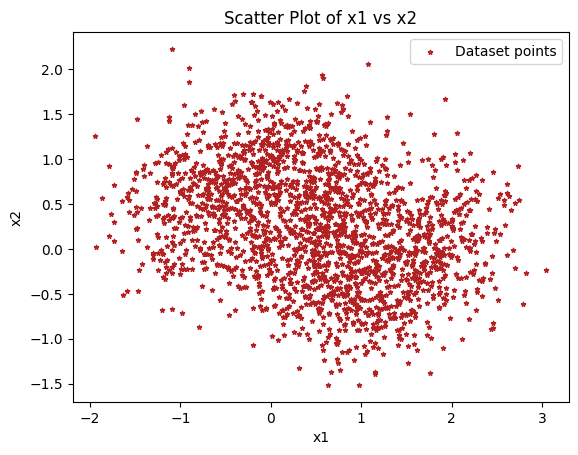

In [3]:
# TODO: Visualize the data using a scatter plot. Be sure to include a legend
ax = data.plot(kind='scatter', x='x1', y='x2', color='firebrick', label='Dataset points', s = 10, marker = '*')

# Adding a title and axis labels
ax.set_title('Scatter Plot of x1 vs x2')  # Title of the plot
ax.set_xlabel('x1')  # Label for the x-axis
ax.set_ylabel('x2')  # Label for the y-axis

# Adding a legend
ax.legend()

# Show the plot
plt.show()

### Task 2.3: Splitting the dataset into train and test sets

Split the dataset into a training set and a testing set. You should have 80% of the data in the training set and 20% of the data in the test set. You are **not** allowed to use any library to do this.

After splitting, print the number of rows in the training set and the test set.


In [4]:
# TODO: split the dataset into train and test sets without using sklearn
# use a 80/20 split
split_index = int(0.8 * len(data))
train_dat_temp = data[:split_index]
test_dat_temp = data[split_index:]
row,col = data.shape
# TODO: print the number of rows in the train and test sets

# Calculate the number of rows for training and testing sets
total_rows = row
train_size = train_dat_temp.size
test_size = test_dat_temp.size

# Split the dataset into training and testing sets
train_set = train_dat_temp
test_set = test_dat_temp

# Print the number of rows in the training and test sets
print("Number of rows in the training set:", len(train_set))
print("Number of rows in the test set:", len(test_set))

print(train_set)
print(test_set)

Number of rows in the training set: 1600
Number of rows in the test set: 400
            x1        x2    y
0     1.388103  0.541000  1.0
1     0.257498  1.034341  0.0
2     0.481232 -0.175209  1.0
3    -0.925897 -0.221878  0.0
4     0.783837 -0.486287  1.0
...        ...       ...  ...
1595 -0.332640  1.010084  1.0
1596  1.452385 -0.727354  1.0
1597  1.413204 -0.614618  1.0
1598 -0.688293  0.008755  0.0
1599  1.908006  0.334803  1.0

[1600 rows x 3 columns]
            x1        x2    y
1600  0.745801 -0.021166  0.0
1601 -1.253429  0.965132  0.0
1602  1.334545 -0.631404  1.0
1603  0.216517  0.218091  0.0
1604  0.187940  0.041160  0.0
...        ...       ...  ...
1995  0.366149  0.110260  1.0
1996  0.342403 -0.467908  1.0
1997 -1.028051  0.842095  0.0
1998  0.738885 -1.028326  1.0
1999  0.374941  0.032100  1.0

[400 rows x 3 columns]


Separate the features and the target variable in the training and testing set into `X_train`, `y_train`, `X_test`, and `y_test`.


In [5]:
# TODO: Separate into X and Y
X_train = train_set[['x1','x2']]
y_train = train_set["y"]
X_test = test_set[['x1','x2']]
y_test = test_set['y']

Use the following `plot_decision_boundary` function for plotting decision boundaries in Part 2 of the assignment


In [6]:
# Do not modify the code below

def plot_decision_boundary(model, X, y):
    '''
    Function to plot the decision boundary of a classification model.
    Parameters:
        model: the classification model
        X: the input features
        y: the target labels
    '''

    # Set min and max values and give it some padding
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.05

    # Generate a grid of points with distance h between them
    x1, x2 = np.meshgrid(np.arange(x1_min, x1_max, h),
                         np.arange(x2_min, x2_max, h))

    # Predict the function value for the whole grid
    Z = model.predict(np.c_[x1.ravel(), x2.ravel()])
    
    # Check if the result is a list and convert to a CuPy array if necessary
    if isinstance(Z, list):
        Z = cp.array(Z)  # Convert the list to CuPy array
    
    # Now convert the CuPy array to a NumPy array
    Z = Z.get()  # Convert CuPy array to NumPy array
    Z = Z.reshape(x1.shape)

    # Plot the contour and training examples
    plt.contourf(x1, x2, Z, cmap=plt.cm.Set1, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='.',
                s=20, linewidth=1, alpha=0.2, cmap=plt.cm.Set1)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title("Dataset")
    plt.show()


### Task 2.4: Decision Tree Classifier

This class will serve as the decision tree classifier. It should have the following methods:

- **init**: This is the constructor of the class. It initializes the class with the maximum depth of the tree. The default value of the maximum depth should be 5, but the user should be able to change it.
- **fit**: This method takes the training data and the training labels as arguments. It should build the decision tree using the training data and labels. You are to use the algorithm discussed in the class to build the decision tree.
- **predict**: This method takes the test data and returns the predicted labels for the test data.

Feel free to add any other methods that you think might be useful.


In [7]:
# TODO: Build a decision tree classifier from scratch
# NOTE: You are allowed to alter method signatures and create as many helper functions as needed
# NOTE: You can also use a completely different implementation than what is stated below

class Node:
    def __init__(self, left=None, right=None, feature=None, threshold=None, value=None):
        self.left = left
        self.right = right
        self.feature = feature
        self.threshold = threshold
        self.value = value

    def is_leaf(self):
        return self.value is not None


class DecisionTree:
    def __init__(self, max_depth=5, min_samples_splits=2, n_features=None):
        self.max_depth = max_depth
        self.min_samples_splits = min_samples_splits
        self.n_features = n_features
        self.root = None

    def fit(self, X, y):
        if not self.n_features:
            self.n_features = X.shape[1]
        
        # with tqdm(total=self.max_depth, desc="Building decision tree", position=0, leave=False) as pbar:
            pbar = 0
            self.root = self.make_tree(X, y, depth=0, pbar=pbar)

    def predict(self, X_test):
        return [self.traverse_tree(x, self.root) for x in X_test]

    def traverse_tree(self, data_point, node):
        if node.is_leaf():
            return node.value
        if data_point[node.feature] <= node.threshold:
            return self.traverse_tree(data_point, node.left)
        else:
            return self.traverse_tree(data_point, node.right)

    def make_tree(self, X, y, depth=0, pbar=None):
        n_samples, n_feats = X.shape
        
        unique_labels = np.unique(y).size
        
        if depth >= self.max_depth or unique_labels == 1 or n_samples < self.min_samples_splits:
            label = self.most_common_label(y)
            return Node(value=label)
    
        feature_ids = np.random.choice(n_feats, self.n_features, replace=False)
    
        best_feat, best_thresh = self.best_split(X, y, feature_ids, pbar)
    
        left_indices, right_indices = self.split(X[:, best_feat], best_thresh)
        
        left = self.make_tree(X[left_indices], y[left_indices], depth + 1, pbar)
        right = self.make_tree(X[right_indices], y[right_indices], depth + 1, pbar)
    
        return Node(left=left, right=right, feature=best_feat, threshold=best_thresh)

    def most_common_label(self, y):
        unique_labels, counts = np.unique(y, return_counts=True)
        most_common_index = np.argmax(counts)
        return unique_labels[most_common_index]

    def best_split(self, X, y, feature_ids, pbar=None):
        best_gain = -1
        best_feature = None
        best_threshold = None

        for feature in tqdm(feature_ids, desc="Finding best split", position=1, leave=False):
            feature_values = X[:, feature]
            thresholds = np.unique(feature_values)

            for threshold in thresholds:
                gain = self.calculate_information_gain(y, feature_values, threshold)

                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def split(self, feature_column, threshold):
        left_indices = np.where(feature_column <= threshold)[0]
        right_indices = np.where(feature_column > threshold)[0]
        return left_indices, right_indices

    def calculate_entropy(self, y):
        y = cp.asarray(y).astype(cp.int32) 
        y_np = y.get() 
        
        class_counts = np.bincount(y_np)
        probabilities = class_counts / len(y_np)
        
        non_zero_probs = probabilities[probabilities > 0]
        entropy = -np.sum(non_zero_probs * np.log(non_zero_probs))
        
        return entropy


    def calculate_information_gain(self, y, feature_column, threshold):
        parent_entropy = self.calculate_entropy(y)
        
        left_indices, right_indices = self.split(feature_column, threshold)
        
        if len(left_indices) == 0 or len(right_indices) == 0:
            return 0
        
        left_entropy = self.calculate_entropy(y[left_indices])
        right_entropy = self.calculate_entropy(y[right_indices])
        
        weighted_child_entropy = (len(left_indices) / len(y)) * left_entropy + (len(right_indices) / len(y)) * right_entropy

        return parent_entropy - weighted_child_entropy



### Task 2.5: Evaluation

Evaluate the Decision Tree classifier using the testing set. Print the accuracy, precision, recall, and F1 score of the classifier just like you did for the KNN classifier. Also, plot the confusion matrix of the classifier, as a heatmap.

You can also import and use pprint to print and visualize the decision tree. Although it is not mandatory, it can be useful to understand the decision tree better.


In [8]:


# Create a DecisionTree object and train it using the training data


# Convert data to CuPy arrays



X_train_cp = cp.asarray(X_train.to_numpy())
y_train_cp = cp.asarray(y_train.to_numpy())
X_test_cp = cp.asarray(X_test.to_numpy())
y_test_cp = cp.asarray(y_test.to_numpy())

# Fit the DecisionTree model
dt = DecisionTree()
dt.fit(X_train_cp, y_train_cp)
dt_y_pred = dt.predict(X_test_cp)

# Define the evaluation metrics using scikit-learn


metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
results = {}


with tqdm(total=len(metrics), desc="Calculating Metrics", position=0, leave=True) as pbar:
    
    y_test_np = y_test.to_numpy() 
    dt_y_pred_np = cp.asarray(dt_y_pred).get()  
    accuracy = accuracy_score(y_test_np, dt_y_pred_np)
    results["Accuracy"] = accuracy
    pbar.set_postfix({"Accuracy": f"{accuracy:.2f}"}) 
    pbar.update(1)  
    
    precision = precision_score(y_test_np, dt_y_pred_np)
    results["Precision"] = precision
    pbar.set_postfix({"Precision": f"{precision:.2f}"})  
    pbar.update(1) 

    recall = recall_score(y_test_np, dt_y_pred_np)
    results["Recall"] = recall
    pbar.set_postfix({"Recall": f"{recall:.2f}"}) 
    pbar.update(1) 
    f1 = f1_score(y_test_np, dt_y_pred_np)
    results["F1 Score"] = f1
    pbar.set_postfix({"F1 Score": f"{f1:.2f}"})  
    pbar.update(1)

# Print the results
print(f'Accuracy: {float(accuracy):.2f}')
print(f'Precision: {float(precision):.2f}')
print(f'Recall: {float(recall):.2f}')
print(f'F1 Score: {float(f1):.2f}')



Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/4 [00:00<?, ?it/s]

Accuracy: 0.84
Precision: 0.87
Recall: 0.83
F1 Score: 0.85


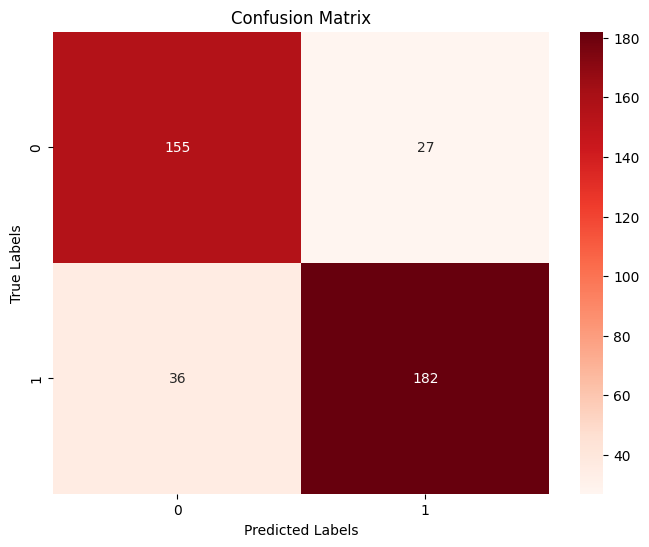

In [9]:
# TODO: Create a confusion matrix and plot it using a heatmap.
# You can use sklearn's confusion_matrix function to create the matrix
# and seaborn's heatmap function to plot it. The libraries has been imported for you

conf_matrix = confusion_matrix(y_test_np, dt_y_pred_np) 
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Reds', fmt='d', cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Task 2.6: Plot Decision Boundary

Similar to the KNN classifier, plot the decision boundary for the decision tree classifier. Also, plot the decision boundary along with a scatter plot of the **Entire Data**. You are supposed to use the `plot_decision_boundary` function given to you at the start


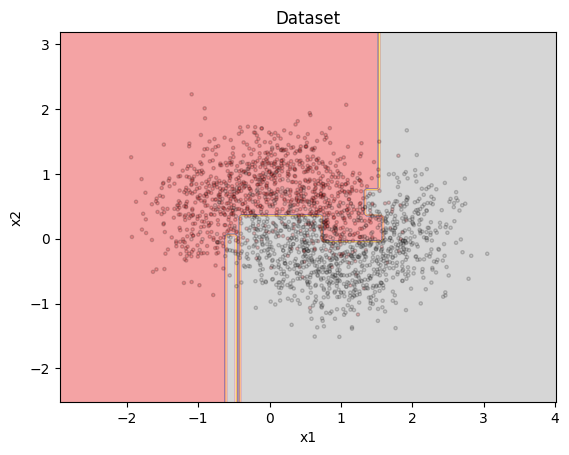

In [10]:
# TODO: Plot the decision boundary on the training set
X_all_np = cp.concatenate([X_train_cp, X_test_cp], axis=0).get() 
y_all_np = cp.concatenate([y_train_cp, y_test_cp], axis=0).get() 
plot_decision_boundary(dt, X_all_np, y_all_np)  


### Task 2.7: Different Max depth values

After seeing how our initial model performed with a default value of Max depth , we will now explore different Max depth values. This step will help us find the best Max depth setting to improve our model's ability to predict accurately

- Use the `plot_decision_boundary` function given above to plot the decision boundaries and scatter plots for different values of `max_depth` from 1 to 25.
- Gather the accuracy for each `max_depth` value on the test set and compare them. Show these comparisons in a graph to easily see which `max_depth` value leads to the best predictions. This will help us choose the best k value for our model.


Training decision trees:   0%|          | 0/25 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Decision Boundary for max_depth = 1


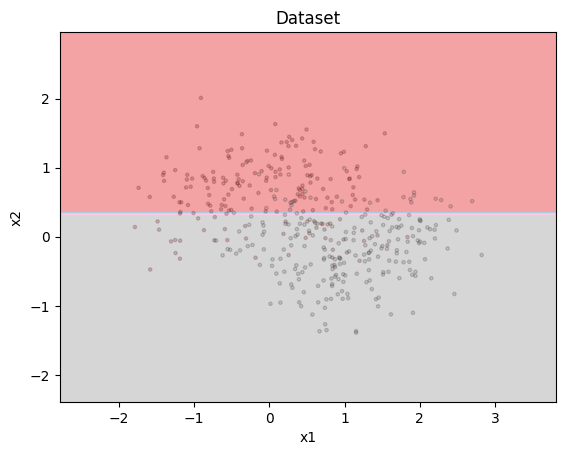

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Decision Boundary for max_depth = 2


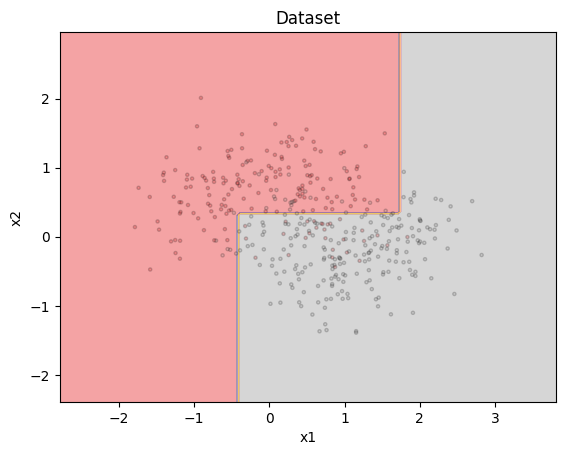

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Decision Boundary for max_depth = 3


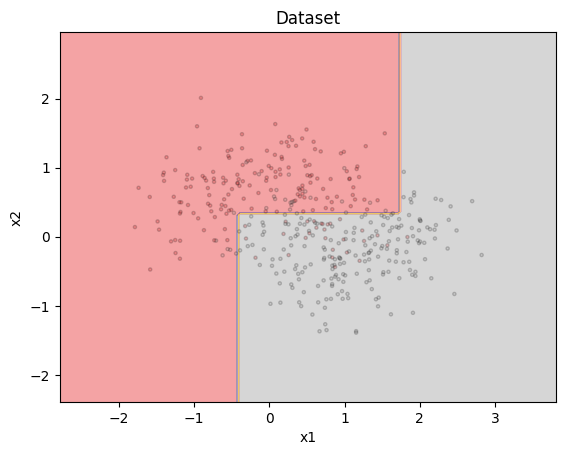

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Decision Boundary for max_depth = 4


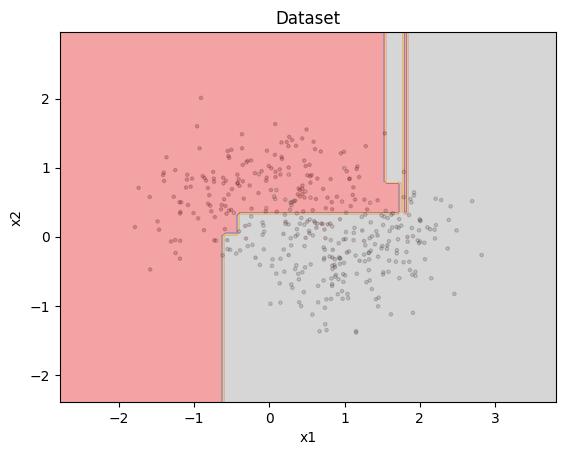

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Decision Boundary for max_depth = 5


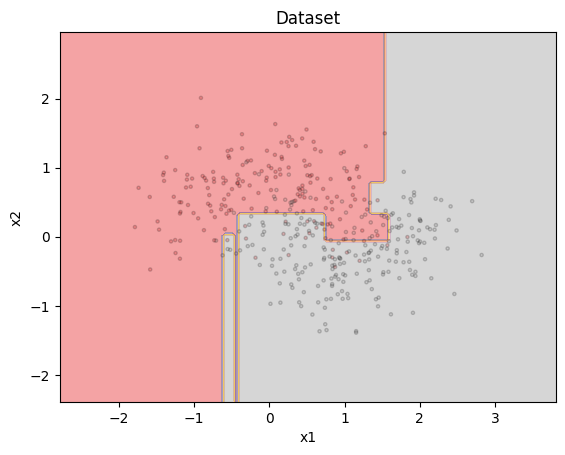

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Decision Boundary for max_depth = 6


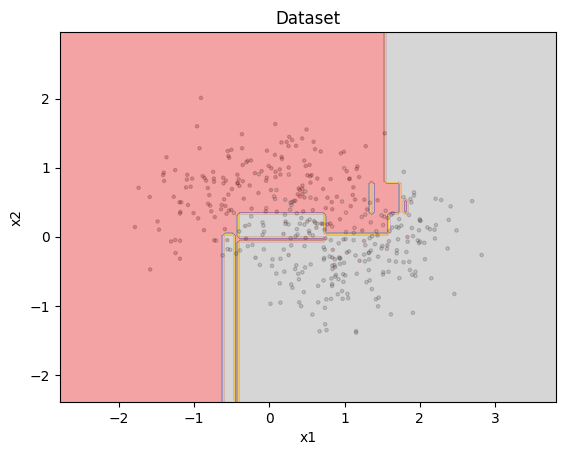

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Decision Boundary for max_depth = 9


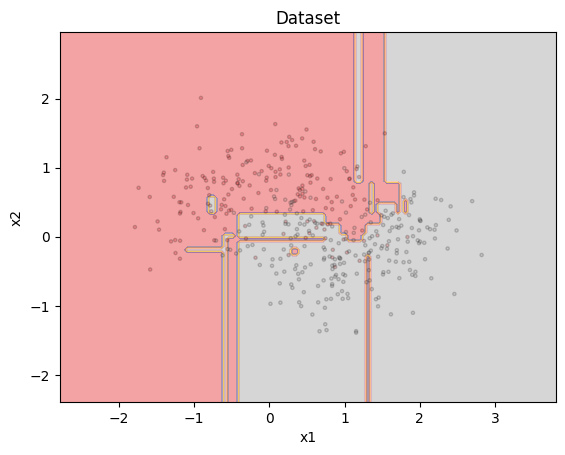

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Decision Boundary for max_depth = 10


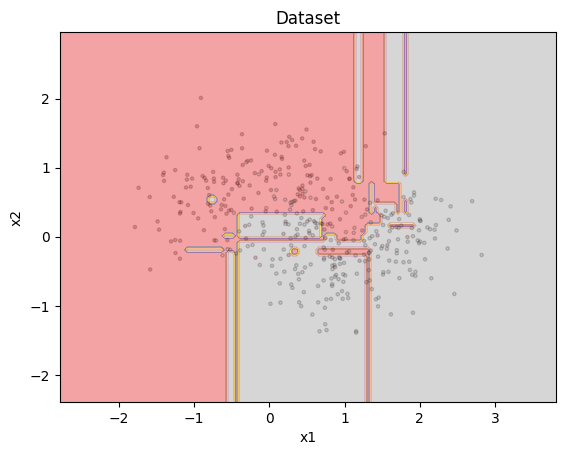

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Decision Boundary for max_depth = 11


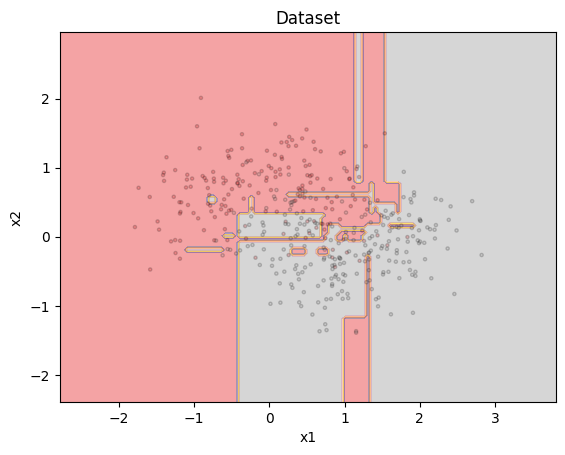

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Decision Boundary for max_depth = 12


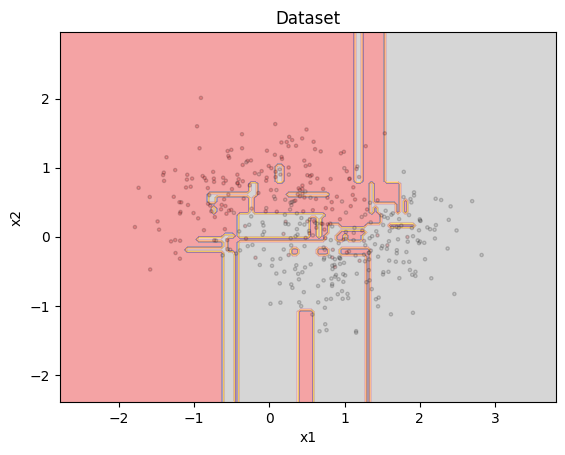

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Decision Boundary for max_depth = 13


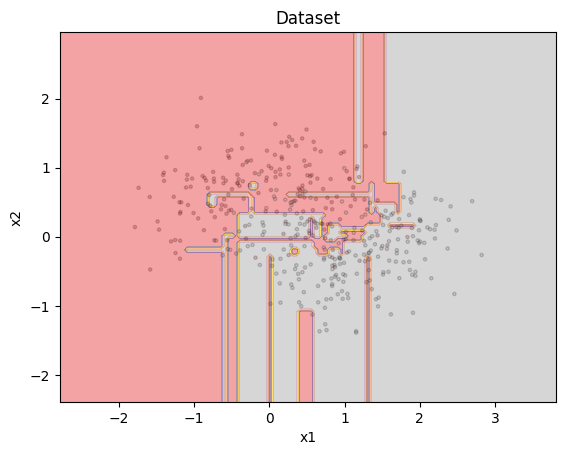

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Decision Boundary for max_depth = 14


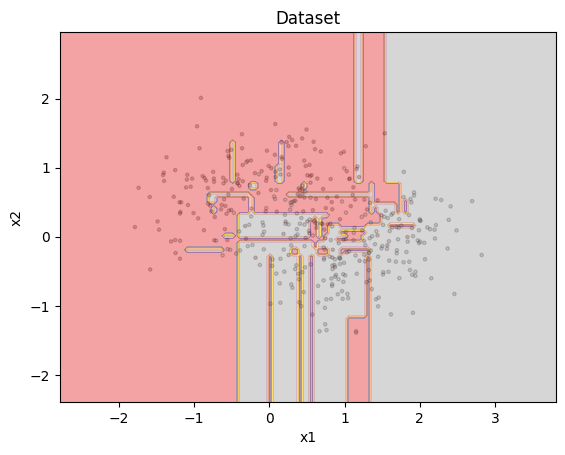

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Decision Boundary for max_depth = 15


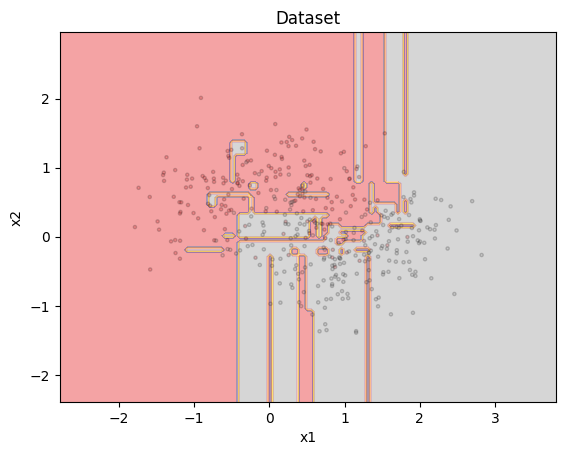

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Decision Boundary for max_depth = 16


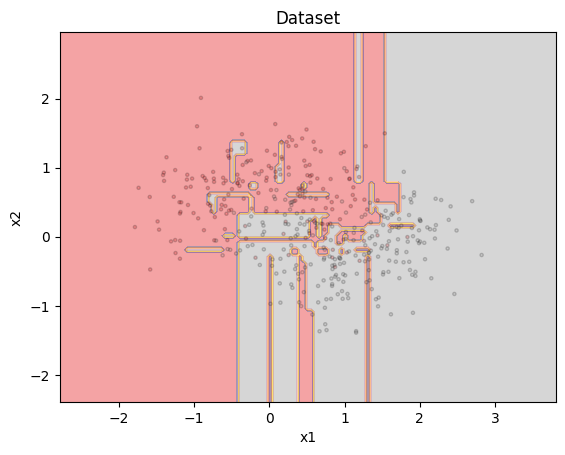

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Decision Boundary for max_depth = 17


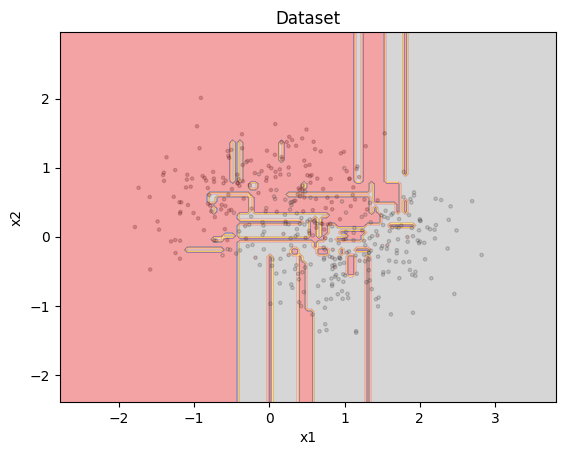

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Decision Boundary for max_depth = 18


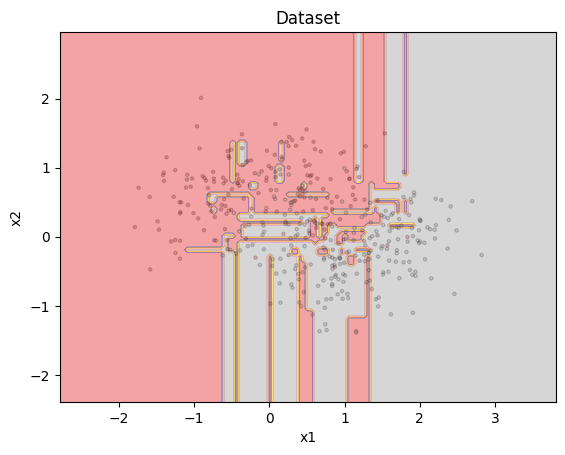

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Decision Boundary for max_depth = 19


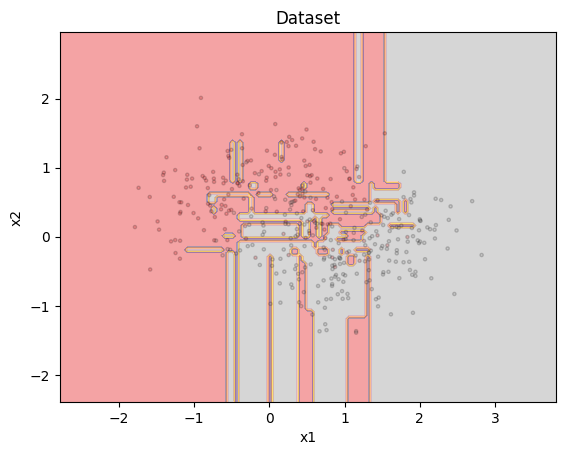

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Decision Boundary for max_depth = 20


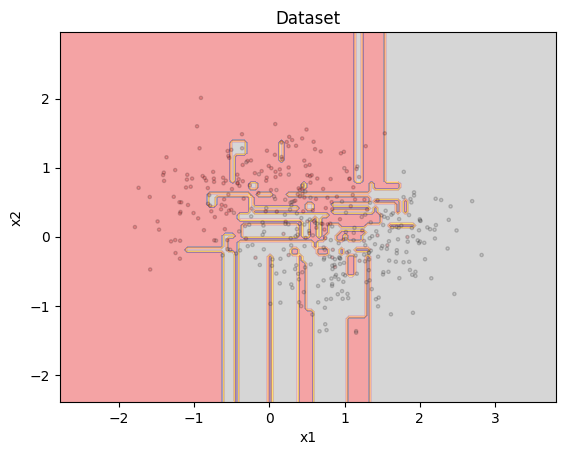

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Decision Boundary for max_depth = 21


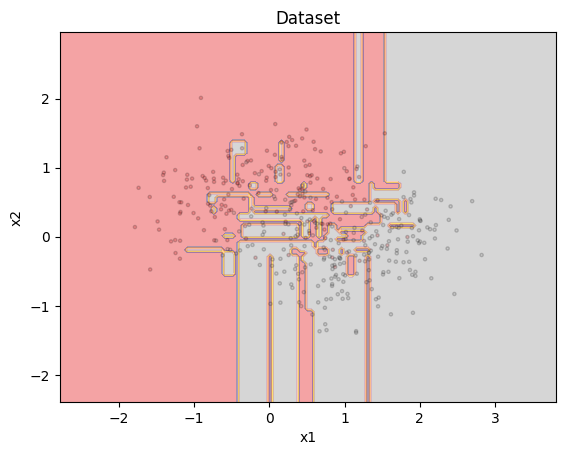

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Decision Boundary for max_depth = 22


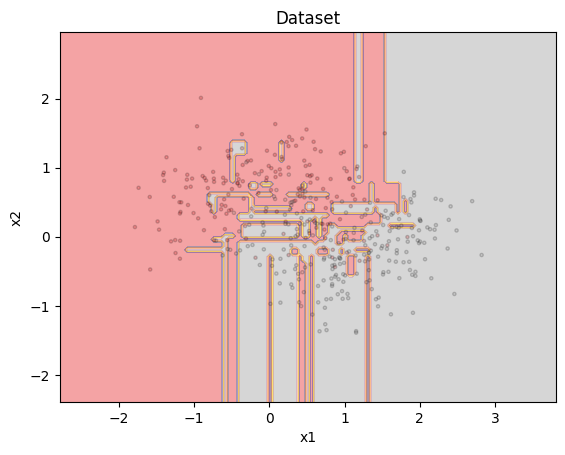

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Decision Boundary for max_depth = 23


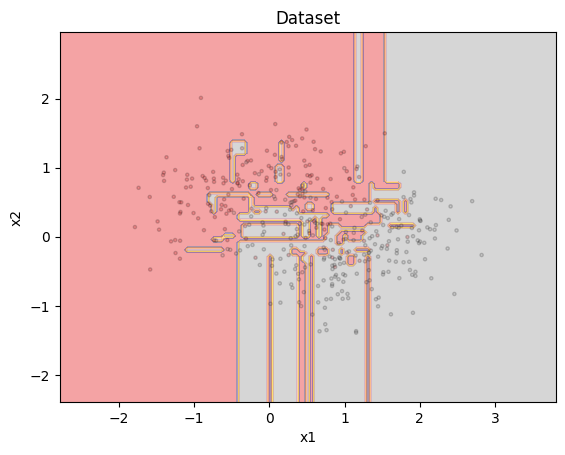

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Decision Boundary for max_depth = 24


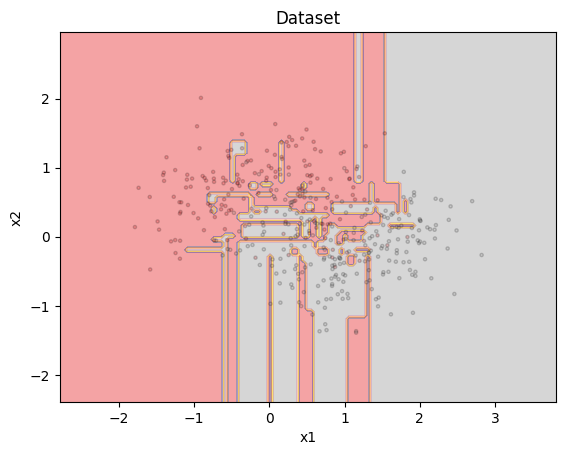

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Finding best split:   0%|          | 0/2 [00:00<?, ?it/s]

Decision Boundary for max_depth = 25


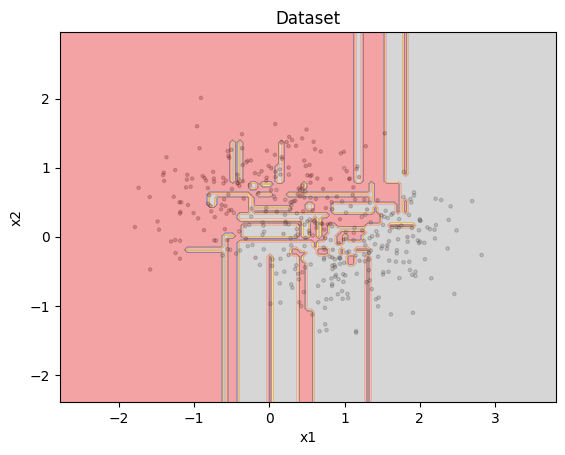

Accuracy for max_depth 1: 0.8075
Accuracy for max_depth 2: 0.8625
Accuracy for max_depth 3: 0.8625
Accuracy for max_depth 4: 0.865
Accuracy for max_depth 5: 0.8425
Accuracy for max_depth 6: 0.8425
Accuracy for max_depth 7: 0.83
Accuracy for max_depth 8: 0.8325
Accuracy for max_depth 9: 0.8275
Accuracy for max_depth 10: 0.8175
Accuracy for max_depth 11: 0.815
Accuracy for max_depth 12: 0.7975
Accuracy for max_depth 13: 0.795
Accuracy for max_depth 14: 0.78
Accuracy for max_depth 15: 0.7775
Accuracy for max_depth 16: 0.775
Accuracy for max_depth 17: 0.7875
Accuracy for max_depth 18: 0.7725
Accuracy for max_depth 19: 0.77
Accuracy for max_depth 20: 0.775
Accuracy for max_depth 21: 0.775
Accuracy for max_depth 22: 0.7775
Accuracy for max_depth 23: 0.7675
Accuracy for max_depth 24: 0.7625
Accuracy for max_depth 25: 0.7675


In [11]:
# TODO: Plot the decision boundary on the test set for different values of max_depth from 1 to 25


model_accuracies = []

with tqdm(total=25, desc="Training decision trees", position=0, leave=True) as pbar:
    for max_depth in range(1, 26):
        tree = DecisionTree(max_depth=max_depth)
        tree.fit(X_train_cp, y_train_cp) 
        
        dt_y_pred = tree.predict(X_test_cp)
    
        accuracy = accuracy_score(y_test_cp.get(), cp.asarray(dt_y_pred).get())  
        
 
        model_accuracies.append(accuracy) 
        pbar.set_postfix({"Max Depth": max_depth, "Accuracy": f"{accuracy:.2f}"})
        pbar.update(1)  

        X_test_np = X_test_cp.get()  
        y_test_np = y_test_cp.get()  
        print(f"Decision Boundary for max_depth = {max_depth}")
        plot_decision_boundary(tree, X_test_np, y_test_np)  
        # plt.title(f"Decision Boundary for max_depth = {max_depth}")
        # plt.show()


for i, acc in enumerate(model_accuracies, start=1):
    print(f"Accuracy for max_depth {i}: {acc}")
    

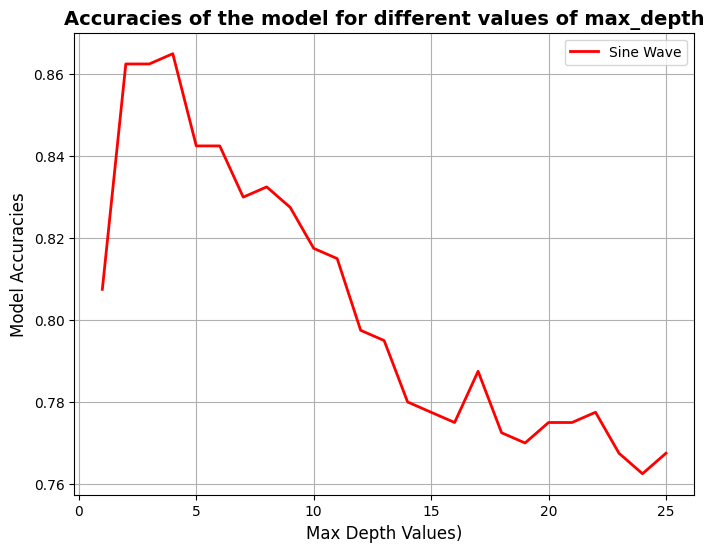

In [14]:
# TODO: Plot the accuracies of the model for different values of max_depth
max_depth_values = list(range(1, 26))
x = max_depth_values 
y = model_accuracies  

plt.figure(figsize=(8, 6))  
plt.plot(x, y, label='Sine Wave', color='r', linewidth=2)

plt.title('Accuracies of the model for different values of max_depth', fontsize=14, fontweight='bold')
plt.xlabel('Max Depth Values)', fontsize=12)
plt.ylabel('Model Accuracies', fontsize=12)

plt.grid(True)

plt.legend()
plt.show()

Q. What can you conclude from you results? Explain your observations.


Ans.


# Part 3: Naive Bayes (250 Marks)

### Introduction

In this part, you will be implementing Naive Bayes model based on the dataset features and task requirements.

For reference and additional details, please go through [Chapter 4](https://web.stanford.edu/~jurafsky/slp3/) of the SLP3 book.

In this assignment, you are provided with `golf_data.csv`. Your task is to:

1. Analyze the datasets and the dataset’s characteristics.
2. Implement both **Naive Bayes** from scratch, adhering to the guidelines below regarding allowed libraries.
3. Finally, apply the corresponding models using the `sklearn` library and compare the results with your own implementation.

### Guidelines:

- Use only **numpy** and **pandas** for the manual implementation of Naive Bayes classifier. No other libraries should be used for this part.
- For the final part of the assignment, you will use **sklearn** to compare your implementation results.


All necessary libraries for this assignment have already been added. You are not allowed to add any additional imports.


In [ ]:
# Standard library imports
import numpy as np

# Third-party library imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.naive_bayes import BernoulliNB
from tqdm import tqdm

## Task 3.1: Loading the Datasets

In this assignment, you are provided with the dataset:

- Golf Dataset (available in CSV format in the given folder)

### Instructions:

**Golf Dataset**: You can find the CSV file of the Golf Dataset in the resources provided with this assignment. This dataset aims to explore factors that influence the decision to play golf, which could be valuable for predictive modeling tasks. ​​

You can read more about Bernoulli Naive Bayes [here](https://medium.com/@gridflowai/part-2-dive-into-bernoulli-naive-bayes-d0cbcbabb775).


In [ ]:
# code here
golf_data = pd.read_csv('file path')  # Replace with correct path

## Task 3.2: Data Preprocessing


### Preprocessing the Golf Dataset


In this task, you will apply one-hot encoding to the categorical columns of the Golf dataset (you can use `pd's` `get_dummies`) and split the data into training and test sets. You can use `sklearn's` `train_test_split` which has been imported for you above. Ensure that the `test_size` parameter is set to 0.3.


In [ ]:
# code here

## Task 3.3: Implementing Naive Bayes from Scratch


## Bernoulli Naive Bayes

### From Scratch

Recall that the Bernoulli Naive Bayes model is based on **Bayes' Theorem**:

$$
P(y \mid x) = \frac{P(x \mid y)P(y)}{P(x)}
$$

What we really want is to find the class \(c\) that maximizes \(P(c \mid x)\), so we can use the following equation:

$$
\hat{c} = \underset{c}{\text{argmax}} \ P(c \mid x) = \underset{c}{\text{argmax}} \ P(x \mid c)P(c)
$$

In the case of **Bernoulli Naive Bayes**, we assume that each word \(x_i\) in a sentence follows a **Bernoulli distribution**, meaning that the word either appears (1) or does not appear (0) in the document. We can simplify the formula using this assumption:

$$
\hat{c} = \underset{c}{\text{argmax}} \ P(c) \prod_{i=1}^{n} P(x_i = 1 \mid c)^{x_i} P(x_i = 0 \mid c)^{1 - x_i}
$$

Where:

- $x_i = 1$ if the $i^{\text{th}}$ word is present in the document.
- $x_i = 0$ if the $i^{\text{th}}$ word is not present in the document.

We can estimate $P(c)$ by counting the number of times each class appears in our training data, and dividing by the total number of training examples. We can estimate $P(x_i = 1 \mid c)$ by counting the number of documents in class $c$ that contain the word $x_i$, and dividing by the total number of documents in class $c$.

### **Important: Laplace Smoothing**

When calculating $P(x_i = 1 \mid c)$ and $P(x_i = 0 \mid c)$, we apply **Laplace smoothing** to avoid zero probabilities. This is essential because, without it, any word that has not appeared in a document of class $c$ will have a probability of zero, which would make the overall product zero, leading to incorrect classification.

**Reason**: Laplace smoothing ensures that we don't encounter zero probabilities by adding a small constant (typically 1) to both the numerator and the denominator. This is particularly useful when a word has never appeared in the training data for a specific class.

The smoothed probability formula is:

$$
P(x_i = 1 \mid c) = \frac{\text{count of documents in class } c \text{ where } x_i = 1 + 1}{\text{total documents in class } c + 2}
$$

This ensures no word has a zero probability, even if it was unseen in the training data.

### Avoiding Underflow with Logarithms:

To avoid underflow errors due to multiplying small probabilities, we apply logarithms, which convert the product into a sum:

$$
\hat{c} = \underset{c}{\text{argmax}} \ \log P(c) + \sum_{i=1}^{n} \left[ x_i \log P(x_i = 1 \mid c) + (1 - x_i) \log P(x_i = 0 \mid c) \right]
$$

You will now implement this algorithm.

<span style="color: red;"> For this part, the only external library you will need is `numpy`. You are not allowed to use anything else.</span>


In [ ]:
# code here
class BNB:
    def __init__(self, X, y):
        self.cond_probs = {}
        self.classes = ...
        self.class_counts = ...
        self.priors = {}
        self.samples, _ = X.shape
        self.priors = ...

    def model_fit(self, X, y):
        pass

    def model_predict(self, X):

        return None

Now use your implementation to train a Naive Bayes model on the training data, and generate predictions for the Validation Set.

Report the Accuracy, Precision, Recall, and F1 score of your model on the validation data. Also display the Confusion Matrix. You are allowed to use `sklearn.metrics` for this.


In [ ]:
# code here

## WELL DONE! You have successfully completed the Assignment! 🎉💯
